In [188]:
import pandas as pd
import random
from IPython import display
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from collections import Counter, defaultdict
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect("game-log.sqlite", 2500)
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
pd.options.display.max_rows = 500
pd.options.display.precision = 2
plt.matplotlib.rcParams['figure.facecolor'] = "#fdf8ed"
plt.matplotlib.rcParams['axes.facecolor'] = (1,1,1,0)
pd.options.display.max_columns = 500

In [201]:
pd.read_sql("""
select
    games.id, descA, descB, winner, datetime(date - 3600*5, 'unixepoch') start,
    format("%0.1f min ago", (unixepoch() - moves.time+1)/60) recent
from games
    left join moves on (games.id == moves.game)
group by moves.game having moves.time == max(moves.time)
order by date desc limit 30;
            """, conn, index_col='id', parse_dates='date')


,descA,descB,winner,start,recent
id,,,,,
4671,moo/one,fast/10k,,2024-02-06 12:14:10,0.4 min ago
4670,moo/one,moo/10k,,2024-02-06 12:13:44,0.4 min ago
4669,od/50k,moo/one,,2024-02-06 12:13:06,0.6 min ago
4668,moo/100k,moo/one,,2024-02-06 12:13:02,0.6 min ago
4667,moo/one,fast/10k,,2024-02-06 12:12:25,1.8 min ago
4666,moo/one,moo/c=2.0/50k,,2024-02-06 12:12:24,0.4 min ago
4665,moo/c=0.75/25k,moo/one,,2024-02-06 12:11:33,0.7 min ago
4664,moo/one,moo/c=1.5/10k,,2024-02-06 12:10:42,2.4 min ago
4663,fastMoo/100k,moo/one,,2024-02-06 12:09:57,0.4 min ago


In [190]:
games_df = pd.read_sql("select * from winners;", conn)
display.display(display.Markdown(f"# Summary: {len(games_df)} finished games"))
pairwise = defaultdict(Counter)
for _, row in games_df.iterrows():
    pairwise[row.loser][row.winner] += 1
pairwise = pd.DataFrame(pairwise)
methods = set(pd.read_sql("select * from methods;", conn).method)
methods = sorted(list(methods))

methods = [x for x in methods if "log" not in x.lower()]

# Add missing pairs
pairwise = pairwise.reindex(methods).T.reindex(methods).T.fillna(0).astype(int)
pairwise.index.name = 'winner'
# Prepend a level
summary = pd.concat({"Pairwise": pairwise}, axis=1)
summary.insert(0, 'Total',     (pairwise.values + pairwise.T.values).sum(axis=1))
summary.insert(0, 'Win count',   pairwise.sum(axis=1))
summary.insert(0, 'Win percent', summary['Win count'] / summary['Total'])
all_elo = defaultdict(lambda: [])
# Run iterations of 100 ELO...
for _ in range(100):
    elo = defaultdict(lambda: 1000)
    # ... each ELO takes 20 random rounds, hopefully to convergence...
    for _ in range(20):
        for winner, loser in pd.read_sql(
                "select winner, loser from winners", conn).sample(frac=1.0).values:
            r1 = 10 ** (elo[winner] / 400)
            r2 = 10 ** (elo[loser] / 400)
            e1 = r1 / (r1+r2)
            e2 = r2 / (r1+r2)
            elo[winner] += 32 * (1.0-e1)
            elo[loser] += 32 * (0.0-e2)
    for k,v in elo.items():
        all_elo[k].append(v)
# after 200 rounds of 20-round ELO, all standard
# errors of the mean (np.std(v)/sqrt(len(v))
# are all within about 3 points
summary.insert(0, 'ELO', {k: np.mean(v) for k,v in all_elo.items()})
summary.sort_values('ELO', ascending=False)

# Summary: 4435 finished games

ELO Win percent Win count Total  Pairwise           \
                                                    fast/100k fast/10k   
winner                                                                   
moo/50k         1345.61        0.79       178   225         6        7   
moo/100k        1339.53        0.79       189   238         8        8   
moo/c=1.5/50k   1334.96        0.79       150   189         5        6   
moo/c=0.75/50k  1328.68        0.79       150   189         5        6   
moo/c=0.75/25k  1311.38        0.77       144   186         5        4   
moo/c=1.0/50k   1307.28        0.77       148   191         7        5   
moo/c=1.0/25k   1257.55        0.73       144   197         5        5   
woo/100k        1248.07        0.71       158   224         6        7   
moo/c=0.1/50k   1196.26        0.66       126   190         4        5   
moo/c=0.75/10k  1190.69        0.66       121   184         5        4   
moo/c=2.0/50k   1188.77        0.66       125   188         5        7   
woo/50k         1170.73        0.64       141   221         4        6   
moo/c=1.5/25k   1149.22        0.60       117   194         3        5   
moo/c=1.0/10k   1135.84        0.59       111   187         4        4   
moo/10k         1134.76        0.60       140   233         5        7   
moo/c=2.0/25k   1108.95        0.57       106   185         2        6   
moo/c=0.1/25k   1107.00        0.58       107   186         1        4   
moo/c=0.1/10k   1087.82        0.54       101   187         5        5   
od/100k         1028.79        0.53       143   269         6       10   
od/50k          1022.48        0.50       130   261         2        5   
fast/100k        978.18        0.48       131   274        10       14   
woo/10k          958.86        0.41        91   220         2        5   
fastMoo/100k     952.86        0.42        99   236         3        7   
moo/c=1.5/10k    936.13        0.39        73   189         2        4   
moo/c=2.0/10k    925.49        0.37        69   186         5        3   
hybrid/50k       914.89        0.40       101   251         3        7   
fastMoo/50k      908.63        0.37        87   234         4        7   
od/10k           902.78        0.36        90   247         3        5   
hybrid/100k      899.46        0.42       113   266         4       12   
fast/50k         870.13        0.35        89   254         2        6   
fastest/100k     860.17        0.35        95   268         6        7   
fastest/50k      809.17        0.29        73   250         4        4   
hybrid/10k       680.20        0.19        49   261         0        9   
fast/10k         661.69        0.19        51   275         1        7   
fastMoo/10k      636.08        0.17        39   235         1        3   
fastest/10k      541.47        0.15        41   270         0        8   

                                                                           \
               fast/50k fastMoo/100k fastMoo/10k fastMoo/50k fastest/100k   
winner                                                                      
moo/50k               6            5           6           5            7   
moo/100k              6            7           8           8            7   
moo/c=1.5/50k         6            4           6           6            6   
moo/c=0.75/50k        5            6           5           5            6   
moo/c=0.75/25k        5            4           5           5            6   
moo/c=1.0/50k         5            4           5           6            7   
moo/c=1.0/25k         5            5           5           4            5   
woo/100k              5            5           7           6            6   
moo/c=0.1/50k         6            6           4           6            4   
moo/c=0.75/10k        5            5           6           4            5   
moo/c=2.0/50k         5            4           5           7            5   
woo/50k               5            4           7       

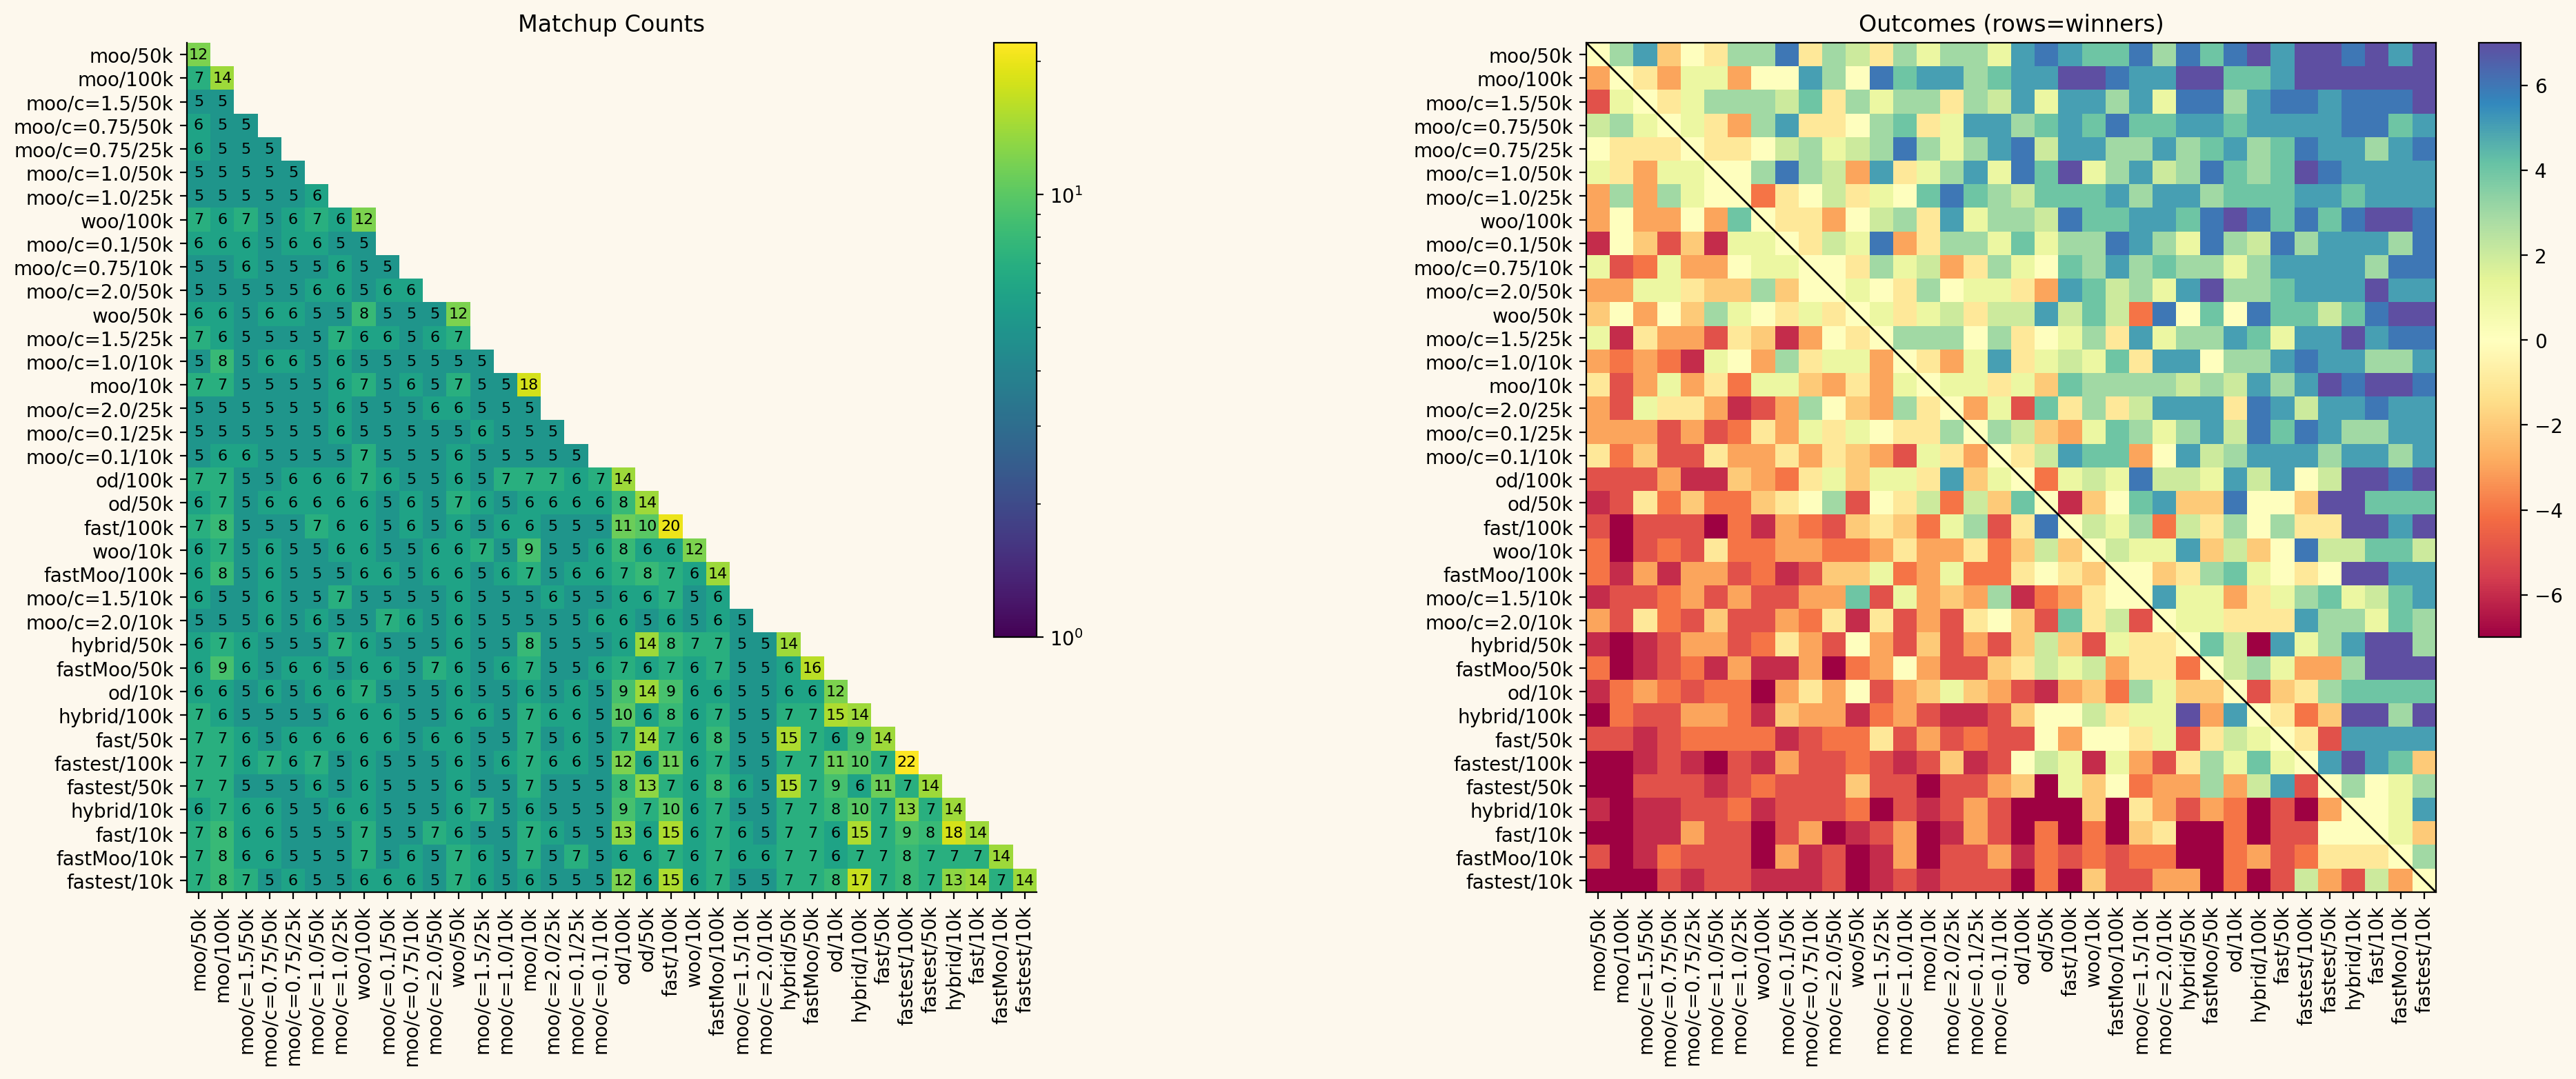

In [191]:
methods = sorted(methods, key=lambda x: -np.mean(all_elo[x]))
matchups = pairwise.loc[methods, methods]
matchups = np.tril(matchups.values + matchups.values.T).astype(float)
matchups[matchups==0] = np.nan
wins = pairwise.loc[methods, methods]
wins = (wins.values - wins.values.T).astype(float)
#wins[np.tril(np.ones(len(wins))) == 1] = np.nan
wins[matchups < 5] = np.nan
wins[np.isnan(wins.T)] = np.nan
#wins[np.isnan(matchups)] = np.nan
SIZE = 8
fig,(axMatchups, axWins) = plt.subplots(1, 2, dpi=200, figsize=(3*SIZE, SIZE))
iM = axMatchups.imshow(matchups, cmap='viridis', norm=plt.matplotlib.colors.LogNorm(), vmin=1)
iW = axWins.imshow(wins, cmap='Spectral', vmin=-7, vmax=7)
cM = axMatchups.inset_axes([0.95, 0.3, 0.05, 0.7])
fig.colorbar(iM, cax=cM)
cW = axWins.inset_axes([1.05, 0.3, 0.05, 0.7])
fig.colorbar(iW, cax=cW)
axMatchups.spines[['top','right']].set_visible(False)
for ax in (axMatchups, axWins):
    plt.sca(ax)
    plt.xticks(np.arange(len(methods)), methods, rotation='vertical');
    plt.yticks(np.arange(len(methods)), methods);
axMatchups.set_title("Matchup Counts")
axWins.plot([0,1],[1,0], transform=axWins.transAxes, c='black', lw=1)
axWins.set_title("Outcomes (rows=winners)")
for i in range(len(methods)):
    for j in range(len(methods)):
        c = matchups[j,i]
        if not np.isnan(c):
            axMatchups.annotate(f"{int(c)}", (i,j), size=8, ha='center',va='center')

In [192]:
pd.read_sql("select * from winners where winner='moo/50k' and loser='moo/100k' or winner='moo/100k' and loser='moo/50k'", conn)

,id,winner,loser
0,1347,moo/50k,moo/100k
1,998,moo/50k,moo/100k
2,1072,moo/100k,moo/50k
3,1120,moo/50k,moo/100k
4,1909,moo/50k,moo/100k
5,1914,moo/100k,moo/50k
6,2287,moo/50k,moo/100k


In [193]:
df = pd.read_sql("select * from matchup_counts where count < 5;", conn)
df = df[[row.a in methods and row.b in methods for _, row in df.iterrows()]]
display.display(display.HTML(
    f"<h1>{len(df)} sparse matchups</h1>"
    f"{len(df)*5 - df['count'].sum()} games left"
))
df

,a,b,count
20,moo/c=0.1/10k,moo/c=0.1/10k,0
23,moo/c=0.1/25k,moo/c=0.1/25k,0
26,moo/c=0.1/50k,moo/c=0.1/50k,0
29,moo/c=0.75/10k,moo/c=0.75/10k,0
32,moo/c=0.75/25k,moo/c=0.75/25k,0
35,moo/c=0.75/50k,moo/c=0.75/50k,0
38,moo/c=1.0/10k,moo/c=1.0/10k,0
41,moo/c=1.0/25k,moo/c=1.0/25k,0
44,moo/c=1.0/50k,moo/c=1.0/50k,0
47,moo/c=1.5/10k,moo/c=1.5/10k,0


# Evaluation speed

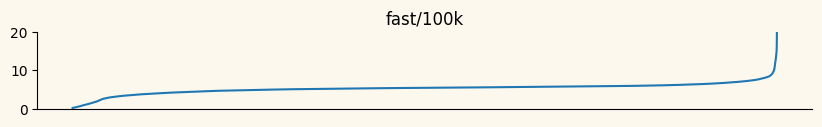

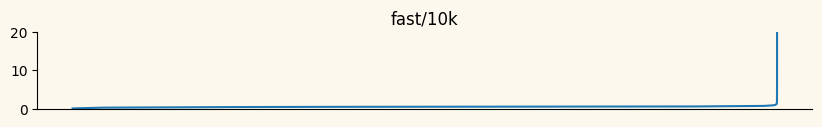

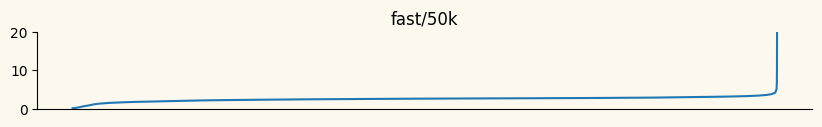

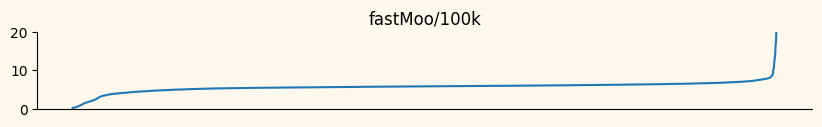

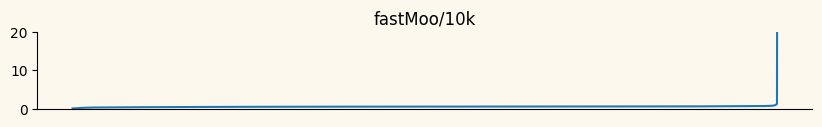

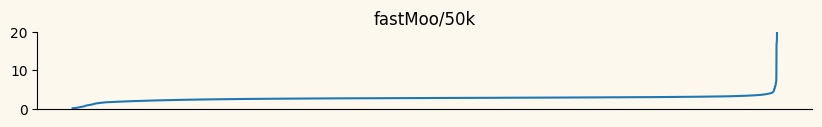

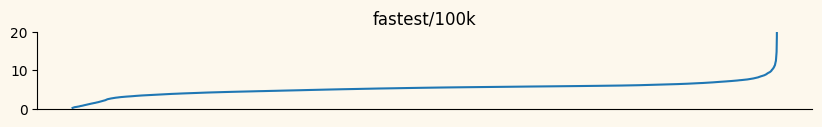

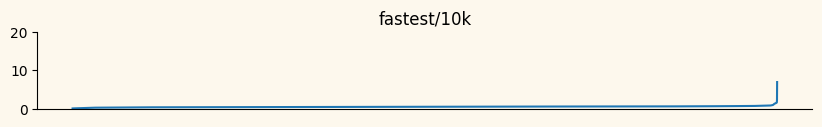

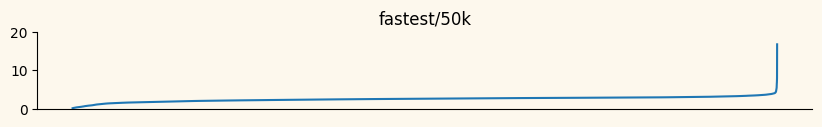

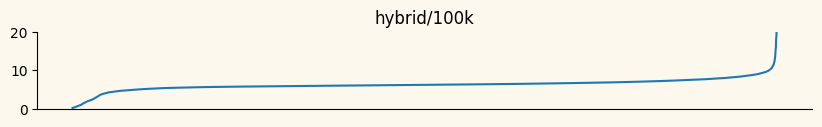

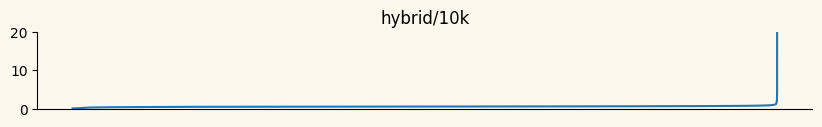

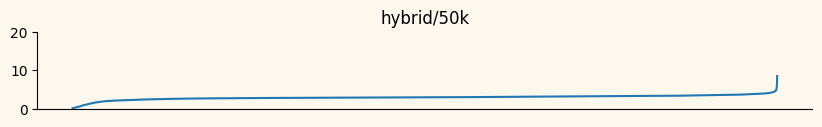

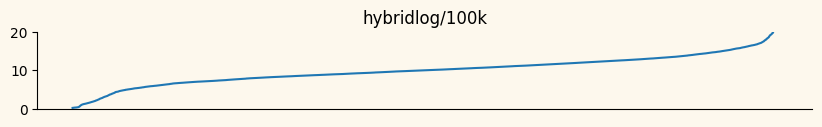

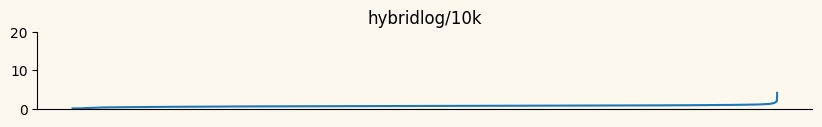

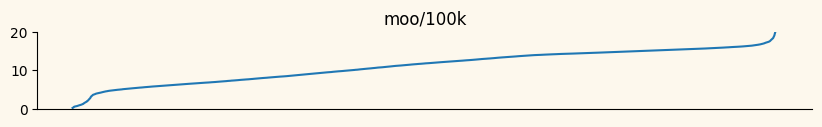

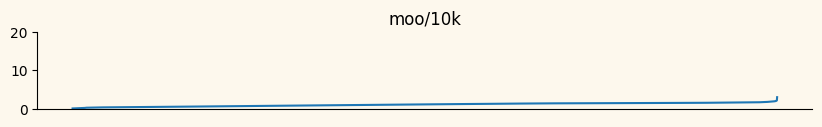

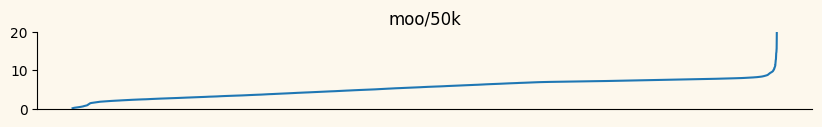

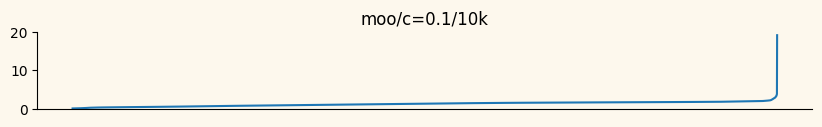

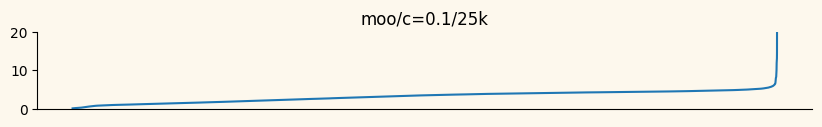

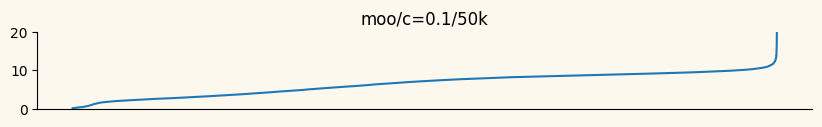

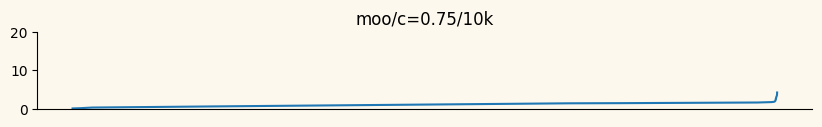

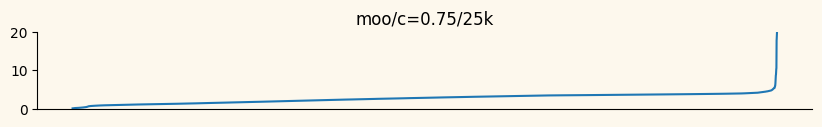

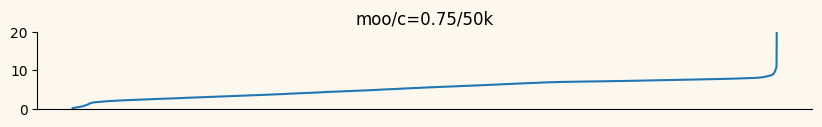

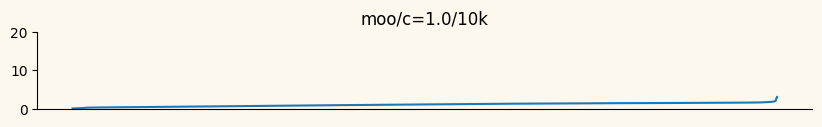

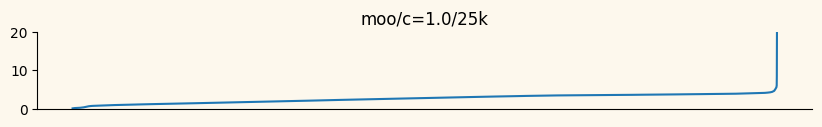

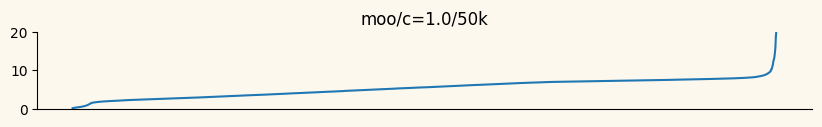

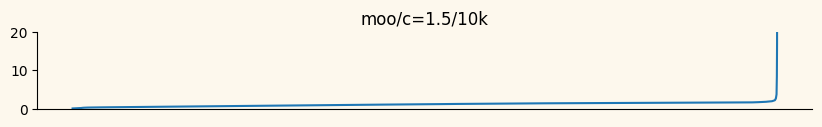

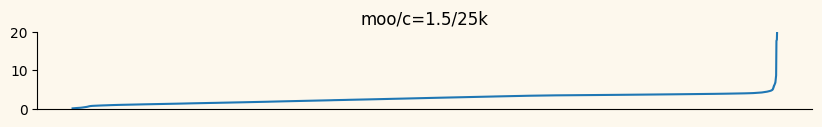

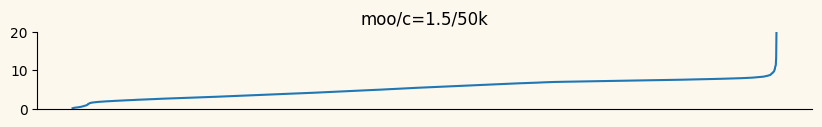

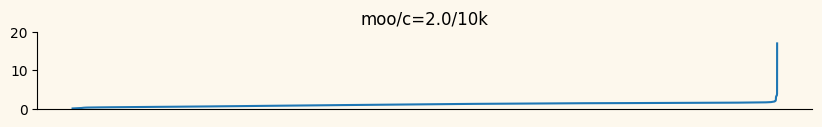

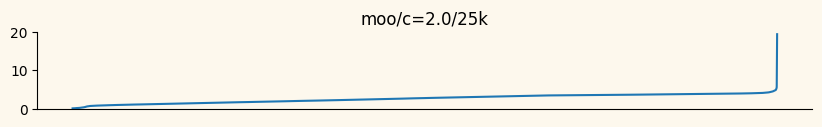

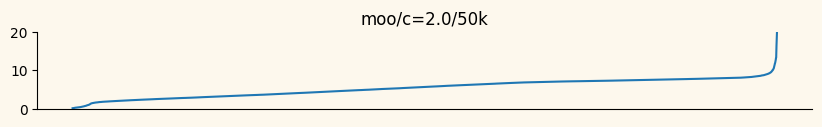

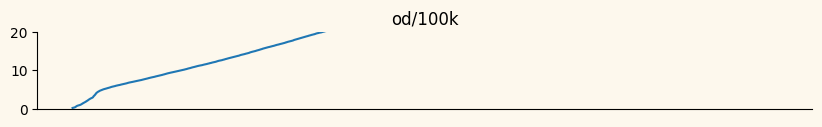

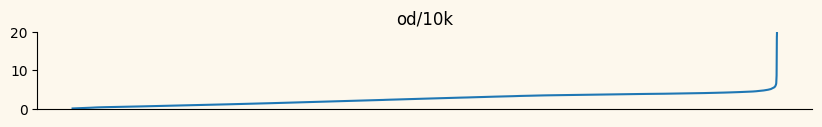

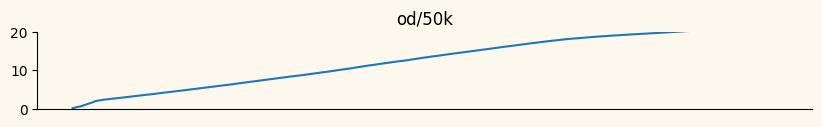

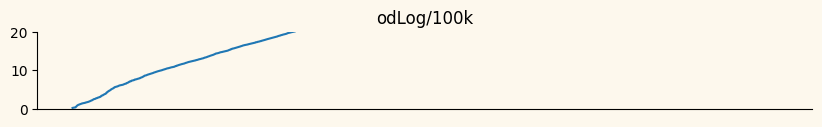

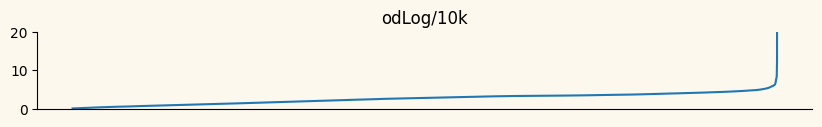

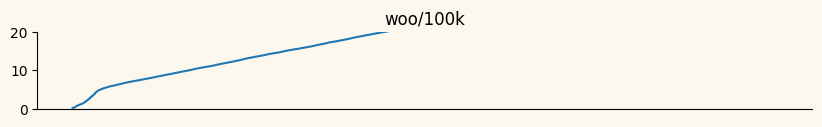

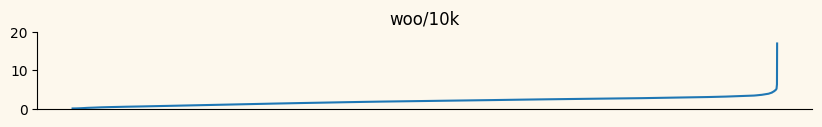

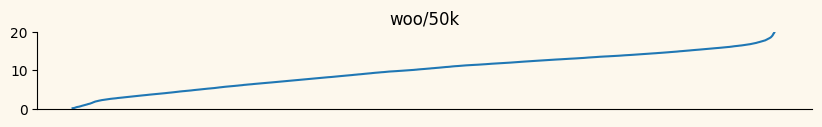

In [194]:
df = pd.read_sql("""
with descriptions as (
    select id, descA desc, "A" player from games union all select  id, descB, "B" from games
) select desc, thinkDuration from moves
inner join descriptions on (moves.game == descriptions.id and moves.player == descriptions.player)
where 0 < thinkDuration and thinkDuration < 60.0
""", conn).groupby('desc')
df.describe()
for desc, times in df.apply(lambda x: x.thinkDuration.tolist()).items():
    fig,ax = plt.subplots(figsize=(10, 1))
    ax.spines[['top','right']].set_visible(False)
    ax.plot(sorted(times))
    ax.set(xticks=[],title=desc,ylim=(0,20))